# Targeted-IMSE applied with the change of variable in polar coordinates

In [1]:
data<-read.csv("data_visco.csv")
data_lasso <- read.csv("data_lasso.csv")
data_AIC <- read.csv("data_AIC.csv")

In [2]:
# We create a function that takes only the values for which the sum is under or equal to 100
Under_100 <-function(X){
    row<-vector()
    for (i in 1:dim(X)[1]){
        if (sum(X[i,-1])>100){
            row<-rbind(row,i)
        }
    }
    X<-X[-row,]
    return(X)
}

### Functions of change of variables

In [3]:
#install.packages("SphericalCubature")
library("SphericalCubature")

Le chargement a nécessité le package : cubature

Le chargement a nécessité le package : SimplicialCubature

Le chargement a nécessité le package : mvmesh

Le chargement a nécessité le package : rcdd

If you want correct answers, use rational arithmetic.
See the Warnings sections in help pages for
    functions that do computational geometry.

Le chargement a nécessité le package : rgl

Le chargement a nécessité le package : geometry

Le chargement a nécessité le package : abind



#### Change of  variables from a simplex to a N-sphere with the N-sphere coordinates

In [4]:
change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    epsilon<-1e-9  # We had a little noise to insure that we can devide by 0
    X<-as.matrix(x[, -1]/100)
    X[which(X == NaN)] <- 0.
    for (i in 1:dim(X)[1]){   #To ensure that we each row is equal to 1 to remove the noise in the column with the highest values in it
        X[ i,23] <- X[ i,23] - (sum(X[i, ]==0.))*epsilon
    }
    X[which(X == 0.)] <- epsilon
    Y<-sqrt(X) #We do a first change of variables y²=x eq y=sqrt(x)
    Y[is.na(Y)] <- 0  #If we have some Nan in our matrix we replace them by zeros
    return(t(as.matrix(rect2polar(t(Y))$phi)))
}

#### Change of  variables from a N-sphere to an simplex with the N-sphere coordinates

In [5]:
#This change of variable is only for a VECTOR
change_in_x_from_phi = function(phi){ #We put in argument vector that takes n-1 values of angles in [0, pi/2]
    Phi=as.matrix(phi)
    r=rep(1,dim(Phi)[1])  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, t(Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)
    new[which(new<1e-4)]<-0   #We obtain sometimes values of order 1e-5 we replace it by 0
    return (as.matrix(new*100))
}


### Targeted IMSE

In [6]:
library("KrigInv") #Pour t-IMSE
library("nloptr") #Pour la fonction d'optimisation Cobyla

Le chargement a nécessité le package : DiceKriging



In [7]:
#t-IMSE STANDARD APPLIQUEE AUX DONNEES 

d = dim(data_lasso)[2]
print(d)
N = 10*d
s = 0
data_Lasso_reduced = change_in_phi_from_x(data_lasso[1:N,-1])
data_Lasso_reduced=cbind(log(data_lasso[,1]),data_Lasso_reduced)
shape = c(dim(data_Lasso_reduced[, -1]))
print(shape)
noise = matrix(runif(prod(shape), min=0.0001, max=0.002),nrow=N)

mod = km(formula = ~1, design = data_Lasso_reduced[,-1]+noise, response = data_Lasso_reduced[,1])


lowerbound = as.vector(rep(0, dim(data_Lasso_reduced[, -1])[2]))
upperbound = as.vector(rep(pi/2, dim(data_Lasso_reduced[, -1])[2]))
max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par


[1] 30


Warning message in sqrt(X):
“Production de NaN”
Warning message in cbind(log(data_lasso[, 1]), data_Lasso_reduced):
“number of rows of result is not a multiple of vector length (arg 1)”


[1] 300  27

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  0.9880455 2.090895 0.1669708 0.003782615 0.7373045 0.1381252 0.003784705 0.003799855 0.3370045 0.003804293 0.003772084 1.624441 0.003786494 1.135568 0.7187035 0.2682901 0.003765019 1.678349 0.00379355 0.2732852 0.003782825 2.185365 0.003780045 0.9308259 1.050779 1.234476 1.906767 
  - best initial criterion value(s) :  -561.1684 

N = 27, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       561.17  |proj g|=       1.7448
At iterate     1  f =       485.55  |proj g|=        1.3636
At iterate    

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
0.8016549,0.280966,1.204061,1.04764,0.2934157,0.918883,1.463552,1.145187,0.4264287,0.1305101,⋯,0.6505059,0.8572862,1.393888,1.063766,1.266699,0.9610131,0.9965617,1.285838,0.9060449,1.011973


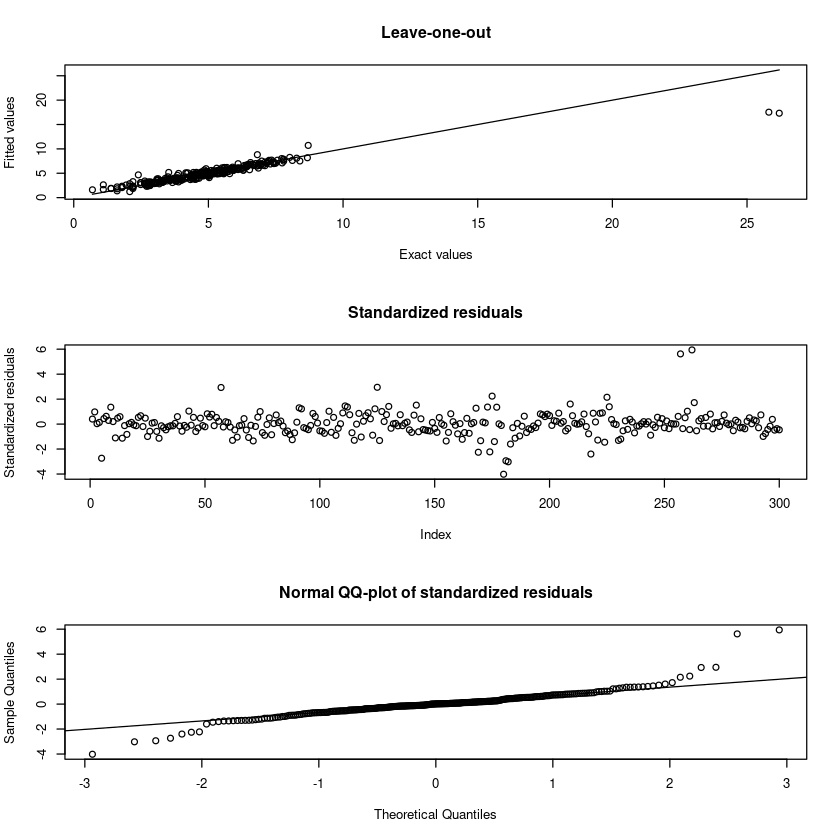

In [8]:
plot(mod)

In [9]:
phi=max_infill_criterion(lower=lowerbound, upper = upperbound, method="tmse", model=mod, T=log(400))$par
phi



Sun May 22 19:50:19 2022
Domains:
 0.000000e+00   <=  X1   <=    1.570796e+00 
 0.000000e+00   <=  X2   <=    1.570796e+00 
 0.000000e+00   <=  X3   <=    1.570796e+00 
 0.000000e+00   <=  X4   <=    1.570796e+00 
 0.000000e+00   <=  X5   <=    1.570796e+00 
 0.000000e+00   <=  X6   <=    1.570796e+00 
 0.000000e+00   <=  X7   <=    1.570796e+00 
 0.000000e+00   <=  X8   <=    1.570796e+00 
 0.000000e+00   <=  X9   <=    1.570796e+00 
 0.000000e+00   <=  X10  <=    1.570796e+00 
 0.000000e+00   <=  X11  <=    1.570796e+00 
 0.000000e+00   <=  X12  <=    1.570796e+00 
 0.000000e+00   <=  X13  <=    1.570796e+00 
 0.000000e+00   <=  X14  <=    1.570796e+00 
 0.000000e+00   <=  X15  <=    1.570796e+00 
 0.000000e+00   <=  X16  <=    1.570796e+00 
 0.000000e+00   <=  X17  <=    1.570796e+00 
 0.000000e+00   <=  X18  <=    1.570796e+00 
 0.000000e+00   <=  X19  <=    1.570796e+00 
 0.000000e+00   <=  X20  <=    1.570796e+00 
 0.000000e+00   <=  X21  <=    1.570796e+00 
 0.000000e+00   <= 

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
0.8016549,0.280966,1.204061,1.04764,0.2934157,0.918883,1.463552,1.145187,0.4264287,0.1305101,⋯,0.6505059,0.8572862,1.393888,1.063766,1.266699,0.9610131,0.9965617,1.285838,0.9060449,1.011973


In [10]:
change_in_x_from_phi(phi)
sum(change_in_x_from_phi(phi))
phi

48.37462,47.65609,0.5103417,0.8634131,2.378417,0.07991979,0,0.02311964,0.09325802,0.01892187,⋯,0,0,0,0,0,0,0,0,0,0


[1] 99.9981

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27
0.8016549,0.280966,1.204061,1.04764,0.2934157,0.918883,1.463552,1.145187,0.4264287,0.1305101,⋯,0.6505059,0.8572862,1.393888,1.063766,1.266699,0.9610131,0.9965617,1.285838,0.9060449,1.011973


In [11]:
pointProche <- function(x_new, data){
    X_cher = data[,c(-1)]
    argmin = 1
    minvalue = norm(x_new- X_cher[1,], type = "2") 
    n_points = nrow(data) #longeur da la base de données

    for (i in 2:n_points){
        mse = norm(x_new- X_cher[i,], type = "2")
        
        if (mse < minvalue){
            minvalue = mse 
            argmin = i
        }
    }
    print(argmin)
    return (data[argmin,])
}

In [12]:
new_point_phi = pointProche(phi, change_in_phi_from_x(data_lasso))
new_point_phi = t(as.data.frame(new_point_phi))
change_in_x_from_phi(new_point_phi)

t(change_in_x_from_phi(new_point_phi))

data_lasso[6982,]

[1] 6982


0,16.06,16.06,0,0,7.56,0,0.63,0,0,⋯,0,0,0,23.62,0,1.27,2.28,0,0,18.69


0.00
16.06
16.06
0.00
0.00
7.56
0.00
0.63
0.00
0.00
0.00


,vis,X__3,X__4,X__8,X__10,X__17,X__18,X__29,X__30,X__43,⋯,X__84,X__86,X__106,X__109,X__113,X__115,X__117,X__133,X__138,autres
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6982,7,0,16.06,16.06,0,0,7.56,0,0.63,0,⋯,0,0,0,23.62,0,1.27,2.28,0,0,18.69


# Fonction jouet

In [13]:
fjouet.test<-function(x1, x2){
    return((x1-0.5)**2+(x2-0.5)**2)
}

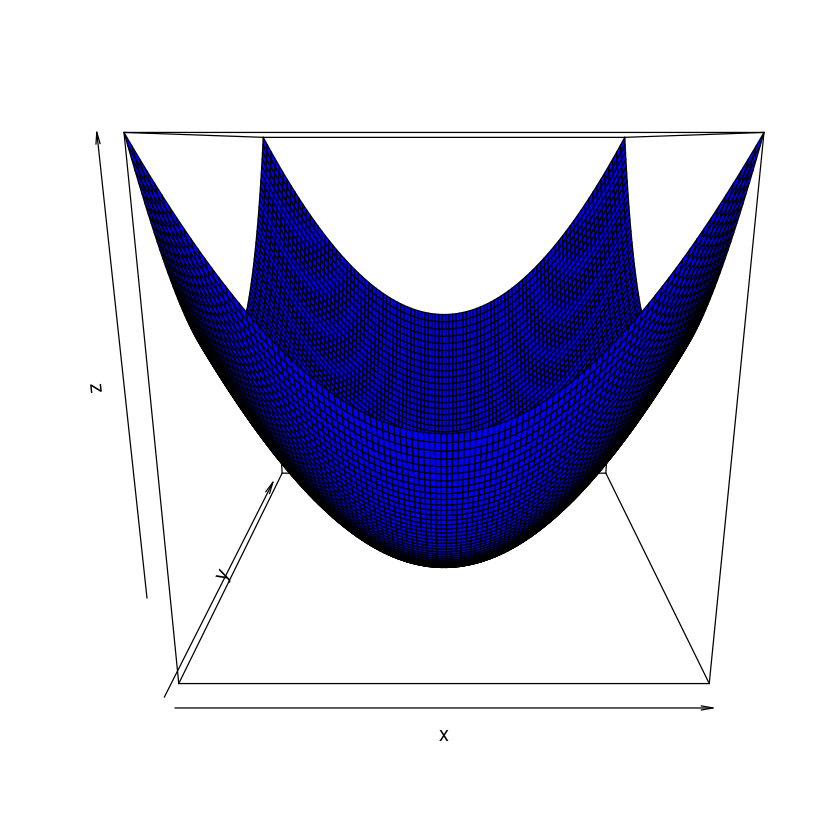

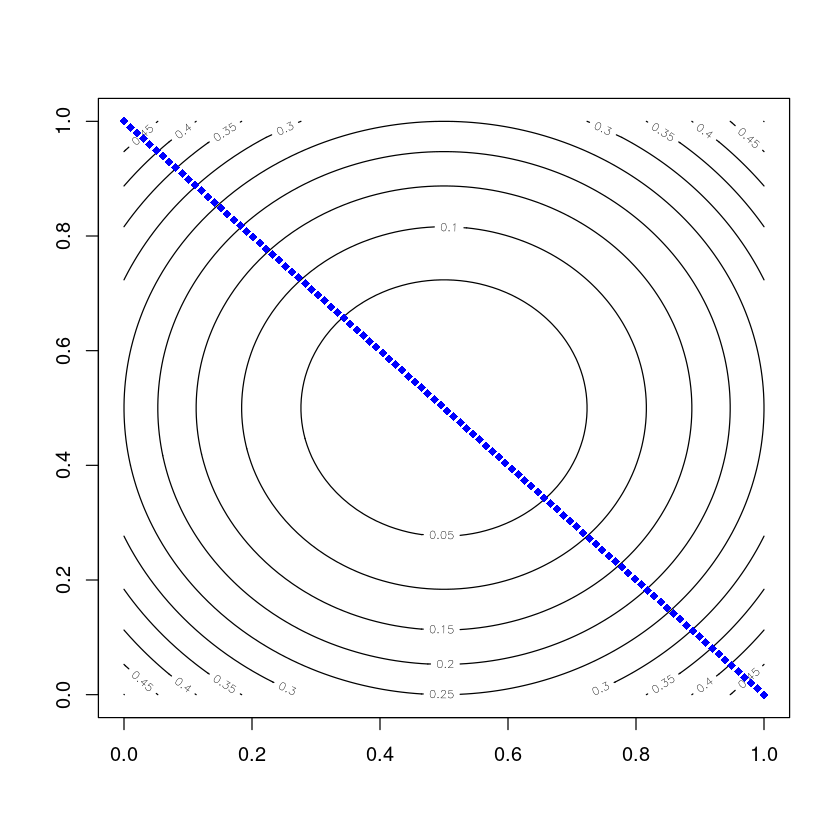

In [14]:
#x = c(0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9) 
#y=1-x

x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)

persp(x,y,z, col='blue')
contour(x,y,z)
lines(x, 1-x, pch=18, col="blue", type="b", lty=2)

In [15]:
jouet<-fjouet.test(0.2, 0.8)
jouet

[1] 0.18

In [16]:
test_change_in_phi_from_x = function(x){ #We put in argument a matrix or a vector that takes n values in a simplex
    Y<-sqrt(x) #We do a first change of variables y²=x eq y=sqrt(x)
     #If we have some Nan in our matrix we replace them by zeros
    return(t(as.matrix(rect2polar((t(Y)))$phi)))
}

In [17]:
test_change_in_x_from_phi = function(phi){ #We put in argumennt a matrix or a vector that takes n-1 values of angles in [0, pi/2]
    Phi=as.matrix(phi)
    r=rep(1,dim(Phi)[1])  #To realize our change of variables considered in the function polar2rect in R it needs to take a radius equals to 1 
    new<-(t(polar2rect(r, t(Phi))))**2  # We realize the change of variables such that f.e. x_1=cos²(theta_1)  #We obtain sometimes values of order 1e-5 we replace it by 0
    return (as.matrix(new))
}

In [19]:
d = 2
N = 10*d

x <- seq(0,1,length.out=100)
y <- 1-x


donne <- cbind(x,y)
resp<- fjouet.test(donne[,1], donne[,2])
mat.donne<-as.data.frame(cbind(resp, donne))

mat.donne



data.change.var <- (test_change_in_phi_from_x(mat.donne[10:N+10,-1]))

data.change.var=as.data.frame(cbind(mat.donne[1:N,1],data.change.var))

data.change.var

mod = km(formula = ~1, design = as.data.frame(data.change.var[,-1]), response = as.data.frame(data.change.var[,1]))

lowerbound = as.vector(rep(0, 1))
upperbound = as.vector(rep(pi/2, 1))



resp,x,y
<dbl>,<dbl>,<dbl>
0.50000000,0.00000000,1.0000000
0.48000204,0.01010101,0.9898990
0.46041220,0.02020202,0.9797980
0.44123049,0.03030303,0.9696970
0.42245689,0.04040404,0.9595960
0.40409142,0.05050505,0.9494949
0.38613407,0.06060606,0.9393939
0.36858484,0.07070707,0.9292929
0.35144373,0.08080808,0.9191919


Warning message in cbind(mat.donne[1:N, 1], data.change.var):
“number of rows of result is not a multiple of vector length (arg 1)”


V1,V2
<dbl>,<dbl>
0.5000000,1.1173281
0.4800020,1.1046282
0.4604122,1.0921634
0.4412305,1.0799136
0.4224569,1.0678613
0.4040914,1.0559904
0.3861341,1.0442865
0.3685848,1.0327367
0.3514437,1.0213291



optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  0.2368606 
  - best initial criterion value(s) :  57.54456 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -57.545  |proj g|=    0.0056948
At iterate     1  f =      -57.868  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value -57.8679

F = -57.8679
final  value -57.867932 
converged


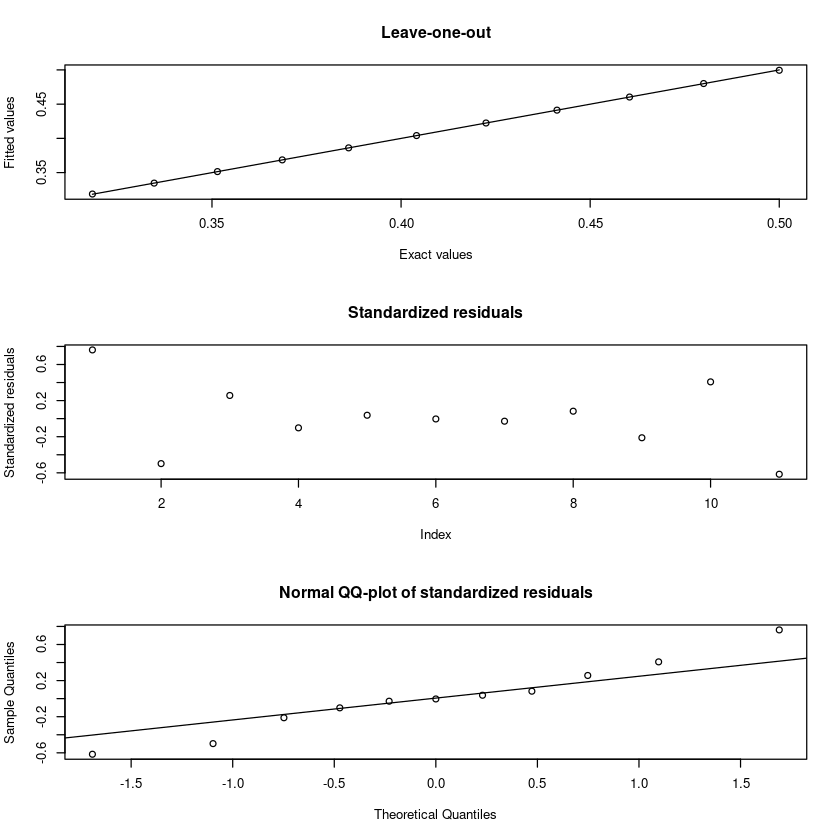

In [20]:
plot(mod)

In [22]:
eps=1e-3
theta=max_infill_criterion(lower=eps, upper = pi/2 - eps, method="tmse", model=mod, T=0.02)$par



Sun May 22 19:51:29 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	1.678018e-03
      1 	1.690617e-03
      2 	1.692103e-03
      3 

In [23]:
fun <- function(phi){
    x <- test_change_in_x_from_phi(phi)
    fjouet.test(x[1], x[2])
}

In [24]:
optimcontrol <- list(method="genoud",pop.size=50)
obj2 <- EGI(T=0.02, model=mod, method="tmse", iter=10, fun = fun, lower=0, upper=pi/2 , optimcontrol=optimcontrol) 



Sun May 22 19:51:39 2022
Domains:
 0.000000e+00   <=  X1   <=    1.570796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	1.677752e-03
      1 	1.690497e-03
      2 	1.692016e-03
      3 

In [25]:
obj2$par
obj2$value

data.change.var....1.
0.6131823
0.3881507
0.7275208
0.0000000
0.7764396
0.6881086
1.5707963
0.8168852
0.8428586
0.8610323


"data.change.var[, 1]"
0.0570077833
0.2545481632
0.0066697168
0.5000000000
0.0001604928
0.0186928264
0.5000000000
0.0019802490
0.0065743899
0.0113540373


[1] 0.0000000 0.2314774 0.3304226 0.4086379 0.4766796 0.5386635 0.5967431
 [8] 0.6522512 0.7061190 0.7590702 0.8117261 0.8646773 0.9185452 0.9740532
[15] 1.0321329 1.0941167 1.1621585 1.2403737 1.3393190 1.5707963

[1]  1 20

[1] 0.500000000 0.400277008 0.311634349 0.234072022 0.167590028 0.112188366
 [7] 0.067867036 0.034626039 0.012465374 0.001385042 0.001385042 0.012465374
[13] 0.034626039 0.067867036 0.112188366 0.167590028 0.234072022 0.311634349
[19] 0.400277008 0.500000000

[1] 20

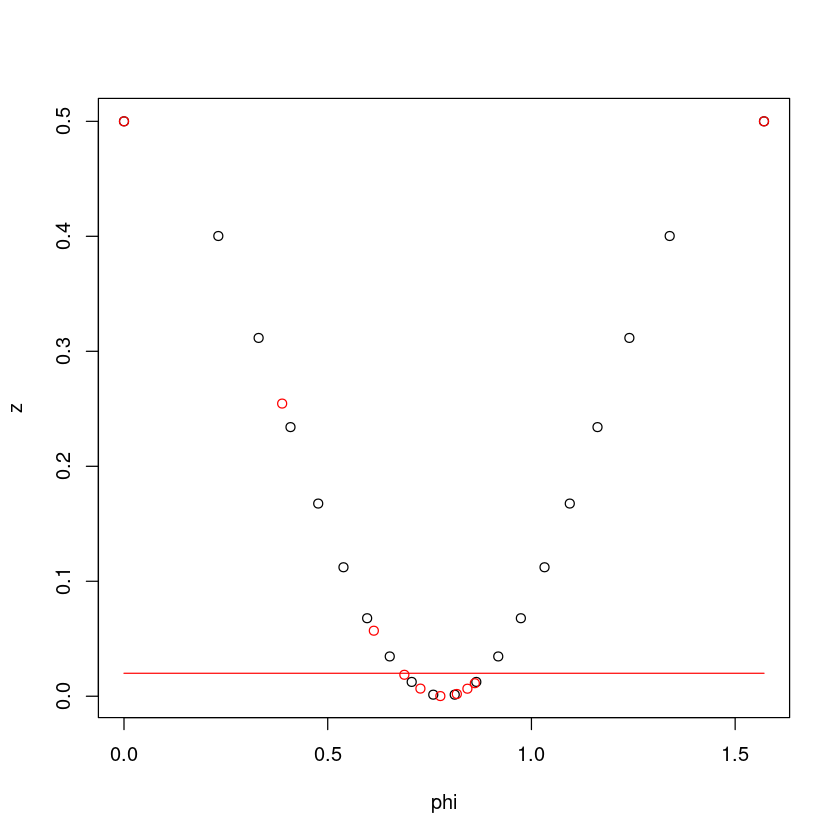

In [26]:
x <- seq(0,1,length.out=20)
y <- 1-x
donne=cbind(x,y)
phi=t(test_change_in_phi_from_x(donne))
sort(phi)
dim(phi)
z=fjouet.test(donne[,1], donne[,2])
z
length(z)
plot(phi,z)
points(obj2$par,obj2$value, col="red")
lines(x=seq(0,pi/2,length.out=100),rep(0.02, 100), col="red")

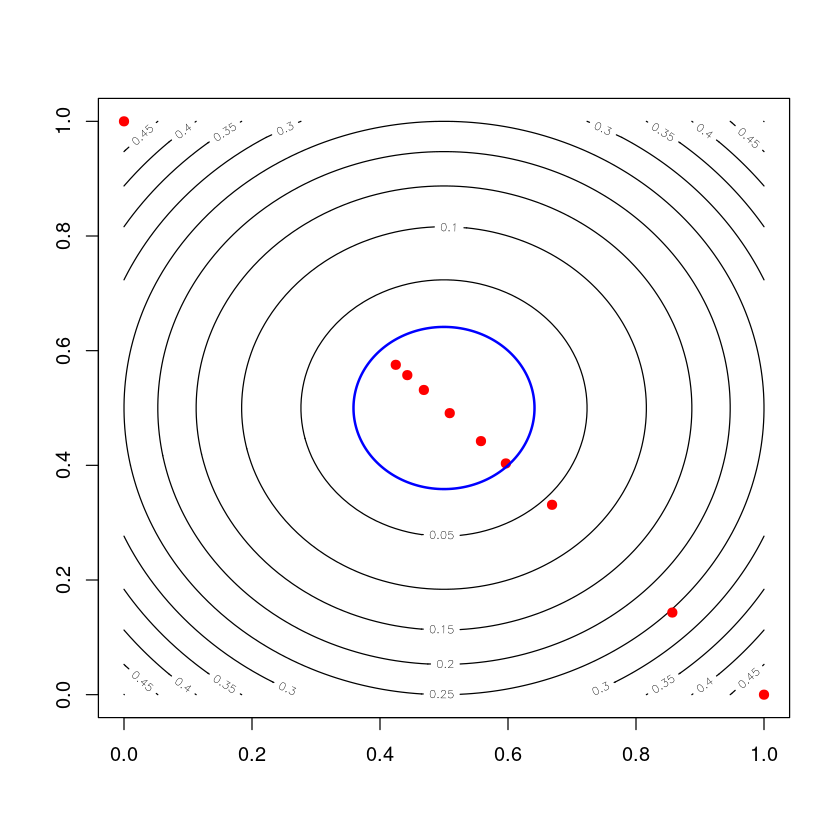

In [27]:
x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)
contour(x,sort(y),z)
change=test_change_in_x_from_phi(obj2$par)
points(change[,1], change[,2], pch=19, col="red")
theta=seq(0,2*pi, length=200)
lines(0.5+sqrt(0.02)*cos(theta), 0.5+sqrt(0.02)*sin(theta), col="blue", lwd=2)

In [28]:
optimcontrol <- list(method="genoud",pop.size=50)
obj3 <- EGI(T=0.0578, model=mod, method="tmse", iter=10, fun = fun, 
           lower=eps, upper=pi/2 - eps, optimcontrol=optimcontrol)  #il faut retrouver 0.33 et 0.67



Sun May 22 19:51:56 2022
Domains:
 1.000000e-03   <=  X1   <=    1.569796e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 10
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	3.692211e-03
      1 	3.695175e-03
      2 	3.695391e-03
      3 

In [29]:
obj3$par
obj3$value

data.change.var....1.
0.6434919
0.4342949
0.7628295
0.0010000
0.6123833
0.8332850
1.5697963
0.2534944
0.8724735
0.5485185


"data.change.var[, 1]"
0.039204951
0.208595866
0.001017996
0.499998000
0.057516631
0.004572296
0.499998000
0.382122029
0.015011550
0.104075108


[1] 0.0000000 0.2314774 0.3304226 0.4086379 0.4766796 0.5386635 0.5967431
 [8] 0.6522512 0.7061190 0.7590702 0.8117261 0.8646773 0.9185452 0.9740532
[15] 1.0321329 1.0941167 1.1621585 1.2403737 1.3393190 1.5707963

[1]  1 20

[1] 0.500000000 0.400277008 0.311634349 0.234072022 0.167590028 0.112188366
 [7] 0.067867036 0.034626039 0.012465374 0.001385042 0.001385042 0.012465374
[13] 0.034626039 0.067867036 0.112188366 0.167590028 0.234072022 0.311634349
[19] 0.400277008 0.500000000

[1] 20

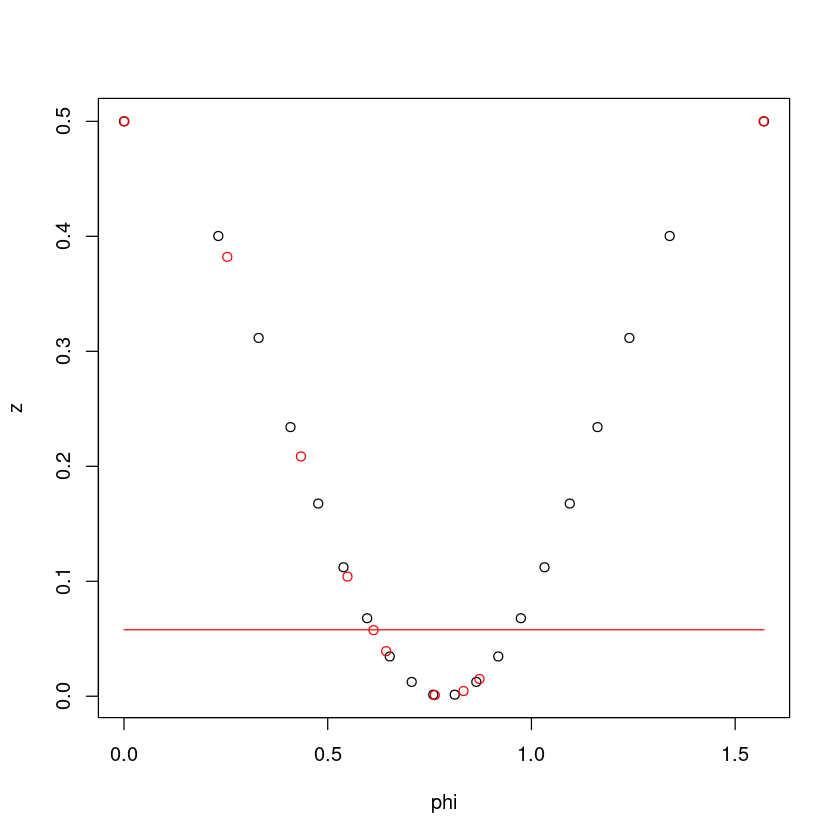

In [30]:
x <- seq(0,1,length.out=20)
y <- 1-x
donne=cbind(x,y)
phi=t(test_change_in_phi_from_x(donne))
sort(phi)
dim(phi)
z=fjouet.test(donne[,1], donne[,2])
z
length(z)
plot(phi,z)
points(obj3$par,obj3$value, col="red")
lines(x=seq(0,pi/2,length.out=100),rep(0.0578, 100), col="red")

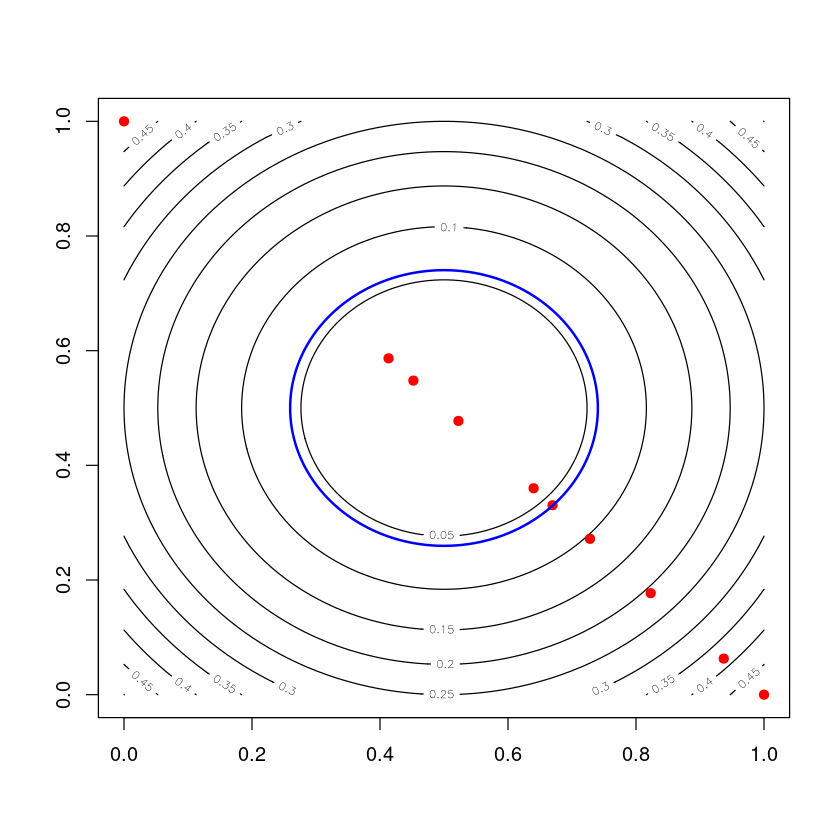

In [31]:
x <- seq(0,1,length.out=100)
y <- sort(1-x)
z <- outer((x-0.5)^2,(y-0.5)^2,`+`)
contour(x,sort(y),z)
change3=test_change_in_x_from_phi(obj3$par)
points(change3[,1], change3[,2], pch=19, col="red")
theta=seq(0,2*pi, length=200)
lines(0.5+sqrt(0.0578)*cos(theta), 0.5+sqrt(0.0578)*sin(theta), col="blue", lwd=2)

# test pour TMSE standard

In [32]:
d = 2
N = 10*d

x <- seq(0,1,length.out=100)
y <- 1-x


donne <- cbind(x,y)
resp<- fjouet.test(donne[,1], donne[,2])
mat.donne<-as.data.frame(cbind(resp, donne))

mat.donne



data.change.var <- mat.donne[10:N+10,]


data.change.var

mod = km(formula = ~1, design = as.data.frame(data.change.var[,-1]), response = as.data.frame(data.change.var[,1]))

lowerbound = as.vector(rep(0, 2))
upperbound = as.vector(rep(1, 2))



resp,x,y
<dbl>,<dbl>,<dbl>
0.50000000,0.00000000,1.0000000
0.48000204,0.01010101,0.9898990
0.46041220,0.02020202,0.9797980
0.44123049,0.03030303,0.9696970
0.42245689,0.04040404,0.9595960
0.40409142,0.05050505,0.9494949
0.38613407,0.06060606,0.9393939
0.36858484,0.07070707,0.9292929
0.35144373,0.08080808,0.9191919


,resp,x,y
,<dbl>,<dbl>,<dbl>
20,0.18982757,0.1919192,0.8080808
21,0.17758392,0.2020202,0.7979798
22,0.16574839,0.2121212,0.7878788
23,0.15432099,0.2222222,0.7777778
24,0.14330170,0.2323232,0.7676768
25,0.13269054,0.2424242,0.7575758
26,0.12248750,0.2525253,0.7474747
27,0.11269258,0.2626263,0.7373737
28,0.10330579,0.2727273,0.7272727



optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  0.2020202 0.2020202 
  - best initial criterion value(s) :  60.63393 

N = 2, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=      -60.634  |proj g|=     0.029841
At iterate     1  f =       -62.16  |proj g|=             0

iterations 1
function evaluations 2
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 2
norm of the final projected gradient 0
final function value -62.1603

F = -62.1603
final  value -62.160254 
converged


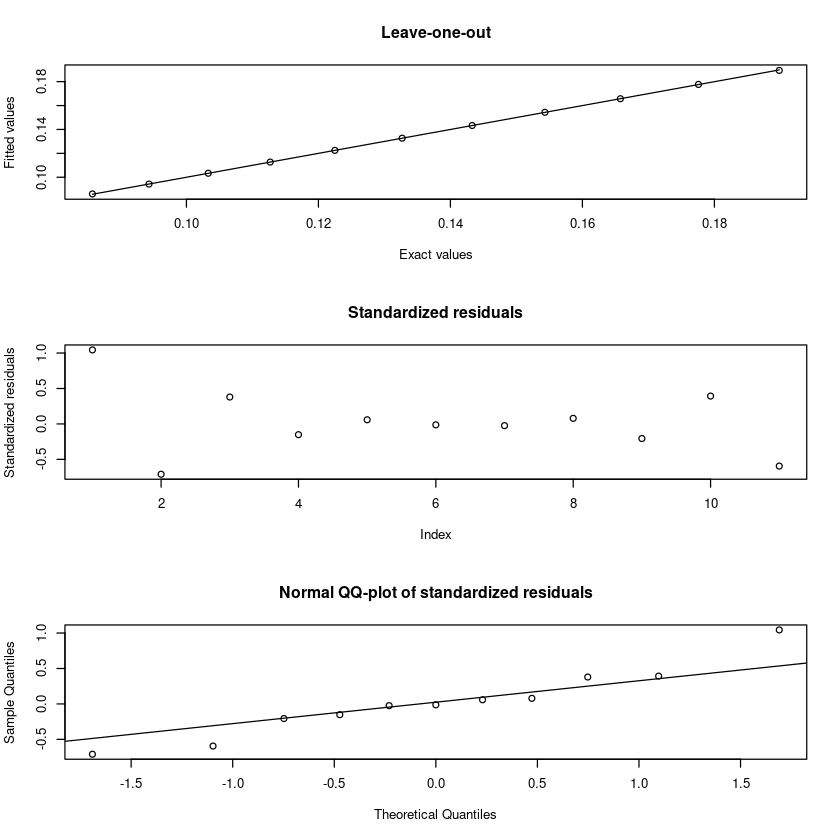

In [33]:
plot(mod)

In [34]:
fun <- function(phi){
    fjouet.test(x[1], x[2])
}

In [35]:
optimcontrol <- list(method="genoud",pop.size=50)
objstandard <- EGI(T=0.02, model=mod, method="tmse", iter=10, fun = fun, lower=lowerbound, upper=upperbound , optimcontrol=optimcontrol) 



Sun May 22 19:52:20 2022
Domains:
 0.000000e+00   <=  X1   <=    1.000000e+00 
 0.000000e+00   <=  X2   <=    1.000000e+00 

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	1
	(2) Uniform Mutation.................. 	0
	(3) Boundary Mutation................. 	0
	(4) Non-Uniform Mutation.............. 	0
	(5) Polytope Crossover................ 	12
	(6) Simple Crossover.................. 	12
	(7) Whole Non-Uniform Mutation........ 	12
	(8) Heuristic Crossover............... 	12
	(9) Local-Minimum Crossover........... 	0

HARD Maximum Number of Generations: 20
Maximum Nonchanging Generations: 2
Population size       : 50
Convergence Tolerance: 1.000000e-09

Using the BFGS Derivative Based Optimizer on the Best Individual Each Generation.
Not Checking Gradients before Stopping.
Not Using Out of Bounds Individuals and Not Allowing Trespassing.

Maximization Problem.


Generation#	    Solution Value

      0 	5.237100e-03
      1

In [36]:
objstandard$par
objstandard$value

,x,y
X,0.4721518,0.5278561
X.1,0.1691262,0.6095863
X.2,0.3935188,0.8382429
X.3,1.0000000,0.0000000
X.4,1.0000000,0.6988252
X.5,0.3083771,0.0000000
X.6,0.8162759,0.2834563
X.7,1.0000000,1.0000000
X.8,0.0000000,1.0000000
X.9,0.6449214,0.0000000


"data.change.var[, 1]"
0.490001
0.490001
0.490001
0.490001
0.490001
0.490001
0.490001
0.490001
0.490001
0.490001
